In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import random
from statsmodels.stats.power import tt_ind_solve_power

def date_converter(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

### Задание 3
**Срок сдачи: 07 апреля 18:00**

В этом задание вы будете работать с выручкой - метрикой с достаточно высокой дисперсией и соответсвенно низкой чувствительностью к изменениям.

Вам предстоит разработать подход по повышению чувствительности этой метрики.
От успеха данной инициативы зависит то, как быстро мы сможем проверять продуктовые гипотезы.

#### Для планирования эксперимента изучите данные и метрики 2 балла:

- Загрузите файл и изучите данные;
- Изучите основные статистики метрики: среднее, стандартное отклонение;
- Изучите то, как эти статистики изменяются внутри срезов: user_segment, region, category

#### Предскажите минимально детектируемый эффект (MDE) 2 балла:

- Для размеров тестовых групп 10,25,50% и длительностей 30, 60, 90 дней предскажите минимально детектируемый эффект;


#### CUPED 6 баллов
Разработайте подход по снижению дисперсии на основе методики CUPED:

- Рассчитайте CUPED метрику на основе данных за периода в 30 дней перед предполагаемым периодом сбора основной выборки и опишите как изменился MDE для выборок 50/50%, собранных за 30 дней (2 бала). 
- Проверьте насколько данный подход подвержен сезональности. Как меняется MDE, если применять данный подход в разные периоды (2 бала). 
- Оптимизируйте подход варьируя количество дней до теста, которые вы будете для расчёта CUPED метрики. Какое максимальное снижение MDE вы смогли достичь (2 бала).



#### * Стратификация 4 балла (задание для получения дополнительных баллов)
Разработайте подход по снижению дисперсии на основе методики стратификации выборок:

- Стратифицируйте выборки внутри срезов user_segment, region, category
- Рассчитайте стратифицированные среднее,стандартное отклонение для этих выборок и MDE для теста 50/50% длительностью 30 дней.
- В каких срезах достигается наибольшее снижение MDE?



#### Описание данныx

event_date - дата 

user_id - идентификатор пользователя

user_segment - сегмент пользователей

region - регион

category - категория авито

revenue_amount - сумма покупок


In [3]:
df = pd.read_csv('user_amount_var_reduction.csv')
df['event_date']=df.event_date.apply(date_converter)

In [4]:
df

,event_date,user_id,user_segment,category,region,revenue_amount
0,2019-06-18,4129257975403696,4626944681007198896,7204754148424990691,2201388710798473628,139
1,2019-06-18,7225254357470025,4626944681007198896,57514010642945023,3048517866726460689,193
2,2019-06-18,8912846500600569,4626944681007198896,5983323600580891431,3048517866726460689,160
3,2019-06-18,20910801279823046,4626944681007198896,6847326422676498281,7762196236856042106,209
4,2019-06-18,34873300821657220,2376074197230840906,3187769798308634693,3855810523611026650,160
...,...,...,...,...,...,...
8625837,2019-12-08,9170823997728769058,2376074197230840906,4658595883120885993,3855810523611026650,133
8625838,2019-12-08,9178869387857307556,4626944681007198896,1472231361867825698,3048517866726460689,63
8625839,2019-12-08,9186690404771258365,2376074197230840906,4546178272531746227,8867014108346120905,168
8625840,2019-12-08,9195678548159495844,2376074197230840906,5983323600580891431,1187552825302355021,118


In [5]:
df.revenue_amount.describe()

count    8.625842e+06
mean     4.009047e+02
std      9.602217e+02
min      1.000000e+00
25%      8.800000e+01
50%      1.670000e+02
75%      4.050000e+02
max      2.881230e+05
Name: revenue_amount, dtype: float64

<AxesSubplot:>

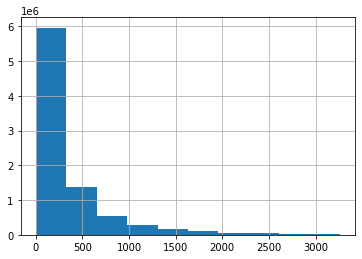

In [6]:
df.revenue_amount[df['revenue_amount']<np.quantile(df['revenue_amount'],q=0.99)].hist()

In [7]:
df.groupby('user_segment').agg({'revenue_amount': ['mean', 'std']})['revenue_amount'].sort_values('std', ascending=False)

,mean,std
user_segment,,
853431062533847667,1094.330305,2392.330098
2376074197230840906,401.615956,571.446013
4626944681007198896,207.760172,285.545686


In [8]:
df.groupby('region').agg({'revenue_amount': ['mean', 'std']})['revenue_amount'].sort_values('std', ascending=False)

,mean,std
region,,
1481836092404435976,709.130762,1819.635279
4848067518890897757,644.019141,1407.455008
5780543780372929118,536.875280,1324.789564
2751451541457411742,391.602676,1241.044595
1611023233668261710,529.945146,1069.926166
...,...,...
6371282152022805074,187.891898,256.364711
928013360687874809,194.400922,239.776537
9173615405044165275,189.498536,230.607352


In [9]:
df.groupby('category').agg({'revenue_amount': ['mean', 'std']})['revenue_amount'].sort_values('std', ascending=False)

,mean,std
category,,
7164285449278522823,1955.979431,3164.815179
2343719193625129042,943.989905,2471.247604
6549025562984299367,410.800302,1899.114650
2923341857645916506,806.675364,1613.975843
7948270325129383019,792.677807,1352.172272
1793067034829450750,497.431001,1073.795206
4409084324312788296,379.733922,889.850240
3358911609809004109,403.792946,791.225418
3187769798308634693,467.654020,790.312625


### MDE

In [14]:
from scipy.stats import t,sem

In [15]:
def choose_date(data, start_date, delta): 
    tmp = data[(data.event_date<start_date)&(data.event_date>=start_date-datetime.timedelta(days=delta))]
    tmp=tmp.groupby(['user_id']).sum().reset_index()
    return tmp

In [16]:
def mde(df, size, alpha=0.01, power=0.8, metrics='revenue_amount'):
    mde = (
        t(len(df)).ppf(1 - alpha/2) 
        + 
        t(len(df)).ppf(power)
          )* df[metrics].std() * ((1/size+1/(1-size))/df[metrics].count())**0.5/df[metrics].mean()
    return mde 

In [17]:
days=[30, 60, 90]
size_group = [0.1, 0.25, 0.5]

In [18]:
for size in size_group:
    for day in days:
        data=choose_date(df, datetime.datetime(2019, 11, 9, 0, 0), day)
        print(f'size group={size}, days={day}, mde={mde(data,size)}')
        

size group=0.1, days=30, mde=0.10970108973632672
size group=0.1, days=60, mde=0.10133541838779497
size group=0.1, days=90, mde=0.09626173184085682
size group=0.25, days=30, mde=0.07600314442759622
size group=0.25, days=60, mde=0.07020723730156414
size group=0.25, days=90, mde=0.0666920841491739
size group=0.5, days=30, mde=0.06582065384179603
size group=0.5, days=60, mde=0.06080125103267697
size group=0.5, days=90, mde=0.057757039104514095


### CUPED

In [19]:
def find_the_preperiod_data(df, delta=30, before_day=30, start_date=datetime.datetime(2019, 10, 9, 0, 0)):
    df=df[['user_id','event_date','revenue_amount']]
    experement_data=df[(df.event_date>start_date)&(df.event_date<=start_date+datetime.timedelta(days=delta))]
    preperiod_data=df[(df.event_date<start_date)&(df.event_date>=start_date-datetime.timedelta(days=before_day))]
    x1=experement_data.groupby(['user_id']).sum().reset_index()
    x2=preperiod_data.groupby(['user_id']).sum().reset_index()
    result=x1.merge(x2, how='left', on='user_id')
    result.fillna(0, inplace=True)
    result.rename(columns={'revenue_amount_x': 'revenue_amount', 'revenue_amount_y': 'pre_revenue_amount'}, inplace=True)
    return result

In [20]:
find_the_preperiod_data(df).head(5)

,user_id,revenue_amount,pre_revenue_amount
0,9257530993551,90,90.0
1,23708868092799,370,370.0
2,39239811475386,469,488.0
3,51991933272698,6152,3874.0
4,74011751568808,69,0.0


In [21]:
def cuped_metric(data):
    data['pre_revenue_amount_average']=data.pre_revenue_amount.mean()
    teta = np.cov(data.revenue_amount,data.pre_revenue_amount, ddof=1)[1,0]/np.var(data.pre_revenue_amount, ddof=1)
    data['cuped_revenue'] = data.revenue_amount - teta * (data.pre_revenue_amount - data.pre_revenue_amount_average)
    return data

In [24]:
cuped_df=cuped_metric(find_the_preperiod_data(df))
cuped_df.head(10)

,user_id,revenue_amount,pre_revenue_amount,pre_revenue_amount_average,cuped_revenue
0,9257530993551,90,90.0,835.314426,780.593789
1,23708868092799,370,370.0,835.314426,801.151259
2,39239811475386,469,488.0,835.314426,790.814763
3,51991933272698,6152,3874.0,835.314426,3336.413301
4,74011751568808,69,0.0,835.314426,842.986031
5,88433173713624,34,68.0,835.314426,744.978560
6,105983947822825,21,0.0,835.314426,794.986031
7,121504130217764,63,0.0,835.314426,836.986031
8,190749703841233,28,0.0,835.314426,801.986031
9,207951365198201,91,0.0,835.314426,864.986031


#### MDE

revenue:

In [25]:
revenue_mde=mde(cuped_df, size=0.5, alpha=0.01, power=0.8, metrics='revenue_amount')
revenue_mde

0.06582065384179603

cuped_revenue:

In [26]:
cuped_revenue_mde=mde(cuped_df, size=0.5, alpha=0.01, power=0.8, metrics='cuped_revenue')
cuped_revenue_mde

0.031059842978399414

In [27]:
print(f'MDE уменьшился в {round(revenue_mde/cuped_revenue_mde,2)} раза')

MDE уменьшился в 2.12 раза


#### Проверьте насколько данный подход подвержен сезональности

In [28]:
mounth=[7, 8, 9, 10, 11]

In [29]:
for m in mounth:    
    pre_data=find_the_preperiod_data(df, delta=30, start_date=datetime.datetime(2019, m, 9, 0, 0))
    cuped_df=cuped_metric(pre_data)
    revenue_mde=mde(cuped_df, size=0.5, alpha=0.01, power=0.8, metrics='revenue_amount')
    cuped_revenue_mde=mde(cuped_df, size=0.5, alpha=0.01, power=0.8, metrics='cuped_revenue')
    print(f'MDE уменьшился в {round(revenue_mde/cuped_revenue_mde,2)} раза в {m} месяце')

MDE уменьшился в 1.78 раза в 7 месяце
MDE уменьшился в 2.06 раза в 8 месяце
MDE уменьшился в 1.88 раза в 9 месяце
MDE уменьшился в 2.12 раза в 10 месяце
MDE уменьшился в 2.05 раза в 11 месяце


#### Оптимизируйте подход варьируя количество дней до теста

In [30]:
days_before=[i for i in range(5,95,5)]

In [31]:
for before_day in days_before:    
    pre_data=find_the_preperiod_data(df, delta=30,before_day=before_day, start_date=datetime.datetime(2019, 10, 9, 0, 0))
    cuped_df=cuped_metric(pre_data)
    revenue_mde=mde(cuped_df, size=0.5, alpha=0.01, power=0.8, metrics='revenue_amount')
    cuped_revenue_mde=mde(cuped_df, size=0.5, alpha=0.01, power=0.8, metrics='cuped_revenue')
    print(f'MDE уменьшился в {round(revenue_mde/cuped_revenue_mde,2)} раза, если брать {before_day} дней до теста')

MDE уменьшился в 1.62 раза, если брать 5 дней до теста
MDE уменьшился в 1.87 раза, если брать 10 дней до теста
MDE уменьшился в 2.02 раза, если брать 15 дней до теста
MDE уменьшился в 2.08 раза, если брать 20 дней до теста
MDE уменьшился в 2.1 раза, если брать 25 дней до теста
MDE уменьшился в 2.12 раза, если брать 30 дней до теста
MDE уменьшился в 2.14 раза, если брать 35 дней до теста
MDE уменьшился в 2.16 раза, если брать 40 дней до теста
MDE уменьшился в 2.1 раза, если брать 45 дней до теста
MDE уменьшился в 2.06 раза, если брать 50 дней до теста
MDE уменьшился в 2.04 раза, если брать 55 дней до теста
MDE уменьшился в 2.0 раза, если брать 60 дней до теста
MDE уменьшился в 1.96 раза, если брать 65 дней до теста
MDE уменьшился в 1.95 раза, если брать 70 дней до теста
MDE уменьшился в 1.92 раза, если брать 75 дней до теста
MDE уменьшился в 1.89 раза, если брать 80 дней до теста
MDE уменьшился в 1.88 раза, если брать 85 дней до теста
MDE уменьшился в 1.86 раза, если брать 90 дней до те

Максимальное снижение в 2.16 раза

### Стратификация 

In [32]:
list_strata=['user_segment', 'category', 'region']

In [36]:
for strat in ['user_segment', 'category', 'region']:
    strata_p = df[[strat,'revenue_amount']].groupby([strat]).count()/df.count()[0]
    data_test=df.join(strata_p, on=strat, rsuffix='_probality')
    std_df=(data_test.revenue_amount.var()/data_test.count()[0])**0.5
    std_strata=((data_test.groupby([strat]).var().revenue_amount*
                 data_test.groupby([strat]).mean().revenue_amount_probality).sum()/data_test.count()[0])**0.5
    
    print(f'Страта {strat}, std_strata = {std_strata}, std_df = {std_df}')

Страта user_segment, std_strata = 0.3140204036144855, std_df = 0.326942053194587
Страта category, std_strata = 0.3206618426638745, std_df = 0.326942053194587
Страта region, std_strata = 0.3229764703528736, std_df = 0.326942053194587


Видно, что стратификация не практически не снизила дисперсию, следовательно, и мде останется практически не именным. Стратификация не дала эффекта в данном случае  